In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v2...


## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [3]:
from src.gpu_info.gpu_info import get_gpu_info

In [4]:
get_gpu_info(0)

Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/gpu_info2/build.ninja...
Building extension module gpu_info2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gpu_info2...


{'name': 'NVIDIA GeForce RTX 4060 Laptop GPU',
 'luid': '',
 'luidDeviceNodeMask': 0,
 'totalGlobalMem': 8325824512,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'memPitch': 2147483647,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim[0]': 1024,
 'maxThreadsDim[1]': 1024,
 'maxThreadsDim[2]': 64,
 'maxGridSize[0]': 2147483647,
 'maxGridSize[1]': 65535,
 'maxGridSize[2]': 65535,
 'clockRate': 2250000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 9,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'deviceOverlap': 1,
 'multiProcessorCount': 24,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'maxTexture2D': 131072,
 'maxTexture2DMipmap': 32768,
 'maxTexture2DLinear': 131072,
 'maxTexture2DGather': 32768,
 'maxTexture3D': 16384,
 'maxTexture3DAlt': 8192,
 'maxTextureCubemap': 32768,
 'maxTexture1DLayered': 32768,
 'maxTextu

### define inputs

In [5]:
S = 1024 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 256 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [6]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.

# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [7]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [8]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [9]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_C_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [10]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)
dQs_pt_half, dKs_pt_half, dVs_pt_half, dIgs_pt_half, dFgs_pt_half, delta_C_pt_half, delta_D_pt_half, delta_Dtilde_pt_half, delta_fbar_pt_half, mat_P_pt_half, mat_R_pt_half = vlstm_bw_torch_obw(
    delta_Htilde=dHs_half,
    queries=qs_half,
    keys=ks_half,
    values=vs_half,
    igate_preact=igs_half,
    fgate_preact=fgs_half,
    var_n=n_pt_half,
    var_m=m_pt_half,
)
dQs_pt_half.dtype, delta_D_pt_half.dtype

(torch.float16, torch.float16)

In [11]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)
dQs_pt_bf16, dKs_pt_bf16, dVs_pt_bf16, dIgs_pt_bf16, dFgs_pt_bf16, delta_C_pt_bf16, delta_D_pt_bf16, delta_Dtilde_pt_bf16, delta_fbar_pt_bf16, mat_P_pt_bf16, mat_R_pt_bf16 = vlstm_bw_torch_obw(
    delta_Htilde=dHs_bf16,
    queries=qs_bf16,
    keys=ks_bf16,
    values=vs_bf16,
    igate_preact=igs_bf16,
    fgate_preact=fgs_bf16,
    var_n=n_pt_bf16,
    var_m=m_pt_bf16,
)
dQs_pt_bf16.dtype, delta_D_pt_bf16.dtype

(torch.bfloat16, torch.bfloat16)

In [12]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_half - dFgs_pt))}")
print(f"bw delta_D match: {torch.allclose(delta_D_pt_half.float(), delta_D_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(delta_D_pt_half - delta_D_pt))}")
print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_pt_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_pt_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_pt_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_pt_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_pt_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_pt_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_pt_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_pt_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_pt_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_pt_bf16 - dFgs_pt))}")


====== Full -> Half ======
fw hs match: False, max diff: 7.2483062744140625
fw n match: False, max diff: 2.8598098754882812
fw m match: False, max diff: 0.8673707246780396
fw D match: False, max diff: 0.7048352956771851
---------------------------------
bw dQs match: False, max diff: 6.760223865509033
bw dKs match: False, max diff: 8.019762992858887
bw dVs match: False, max diff: 4.779045104980469
bw dIgs match: False, max diff: 40.13925552368164
bw dFgs match: False, max diff: 18.103837966918945
bw delta_D match: False, max diff: 179.81982421875
====== Full -> bfloat16 ======
fw hs match: False, max diff: 28.908973693847656
fw n match: False, max diff: 9.38168716430664
fw m match: False, max diff: 4.615557670593262
fw D match: False, max diff: 0.9999998211860657
---------------------------------
bw dQs match: False, max diff: 110.7692642211914
bw dKs match: False, max diff: 100.09133911132812
bw dVs match: False, max diff: 28.28981590270996
bw dIgs match: False, max diff: 202.89611816

### match directly

In [13]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
# dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
#     mat_delta_H=dHs,
#     mat_Q=qs,
#     mat_K=ks,
#     mat_V=vs,
#     vec_igp=igs,
#     vec_fgp=fgs,
#     vec_n=n_cu,
#     vec_m=m_cu,
# )

In [14]:
# hs_cu = hs_pt
# n_cu = n_pt
# m_cu = m_pt
# matD_cu = matD_pt
# dQs_cu = dQs_pt
# dKs_cu = dKs_pt
# dVs_cu = dVs_pt
# dIgs_cu = dIgs_pt
# dFgs_cu = dFgs_pt
# matC_cu = matD_pt

In [15]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)
# dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
#     mat_delta_H=dHs_half,
#     mat_Q=qs_half,
#     mat_K=ks_half,
#     mat_V=vs_half,
#     vec_igp=igs_half,
#     vec_fgp=fgs_half,
#     vec_n=n_cu_half,
#     vec_m=m_cu_half,
# )

before kernel dispatch - float16!
B: 1, NH: 1, S: 1024, DH: 256
blocksxy: 1-2, threadsxy: 16-16, QtileDim: 32, KVtileDim: 16, shared_mem in bytes: 55520


In [16]:
dQs_cu_half, dKs_cu_half, dVs_cu_half, dIgs_cu_half, dFgs_cu_half, matC_cu_half = vlstm_bw_cuda(
    mat_delta_H=dHs_half,
    mat_Q=qs_half,
    mat_K=ks_half,
    mat_V=vs_half,
    vec_igp=igs_half,
    vec_fgp=fgs_half,
    vec_n=n_cu_half,
    vec_m=m_cu_half,
)

before kernel dispatch - float16!
B: 1, NH: 1, S: 1024, DH: 256
blocksxy: 1-2, threadsxy: 16-16, QtileDim: 32, KVtileDim: 16, shared_mem in bytes: 90080


In [17]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)
dQs_cu_bf16, dKs_cu_bf16, dVs_cu_bf16, dIgs_cu_bf16, dFgs_cu_bf16, matC_cu_bf16 = vlstm_bw_cuda(
    mat_delta_H=dHs_bf16,
    mat_Q=qs_bf16,
    mat_K=ks_bf16,
    mat_V=vs_bf16,
    vec_igp=igs_bf16,
    vec_fgp=fgs_bf16,
    vec_n=n_cu_bf16,
    vec_m=m_cu_bf16,
)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 1024, DH: 256
blocksxy: 1-2, threadsxy: 16-16, QtileDim: 32, KVtileDim: 16, shared_mem in bytes: 55520
before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 1024, DH: 256
blocksxy: 1-2, threadsxy: 16-16, QtileDim: 32, KVtileDim: 16, shared_mem in bytes: 90080


In [18]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_half.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_half - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_half.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_half - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_half.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_half - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_half.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_half - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_half.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_half - dFgs_pt))}")
print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu_bf16.float(), dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu_bf16 - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu_bf16.float(), dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu_bf16 - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu_bf16.float(), dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu_bf16 - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu_bf16.float(), dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu_bf16 - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu_bf16.float(), dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu_bf16 - dFgs_pt))}")

Match against pt float32:
====== Full ======


NameError: name 'hs_cu' is not defined

In [ ]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

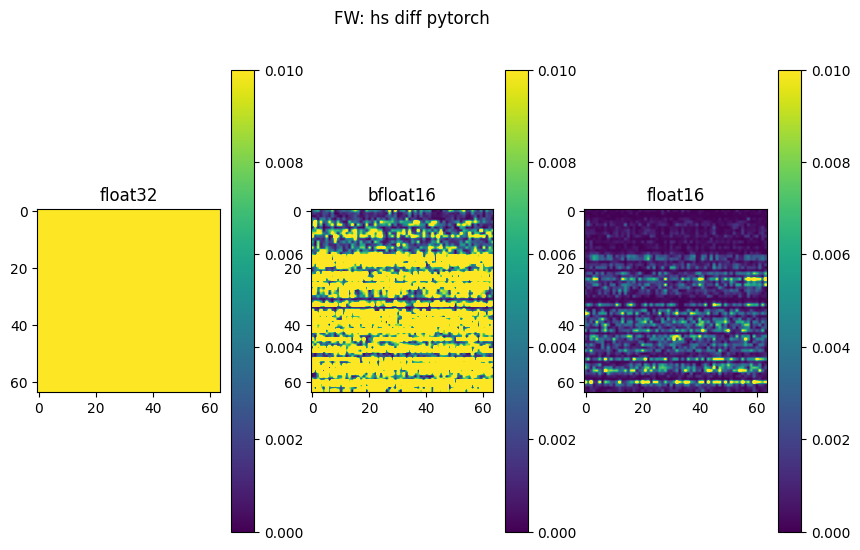

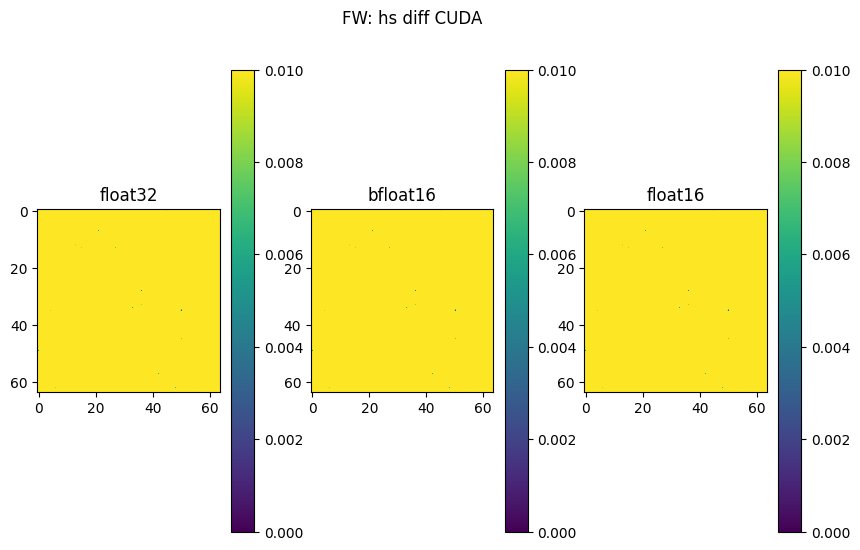

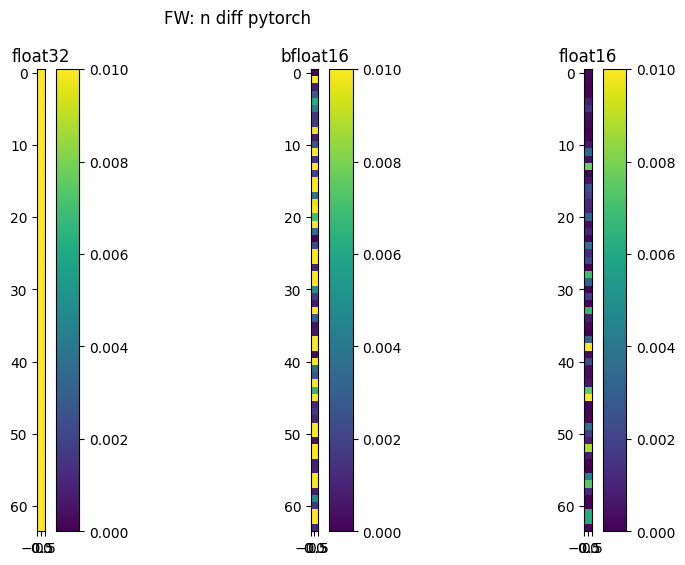

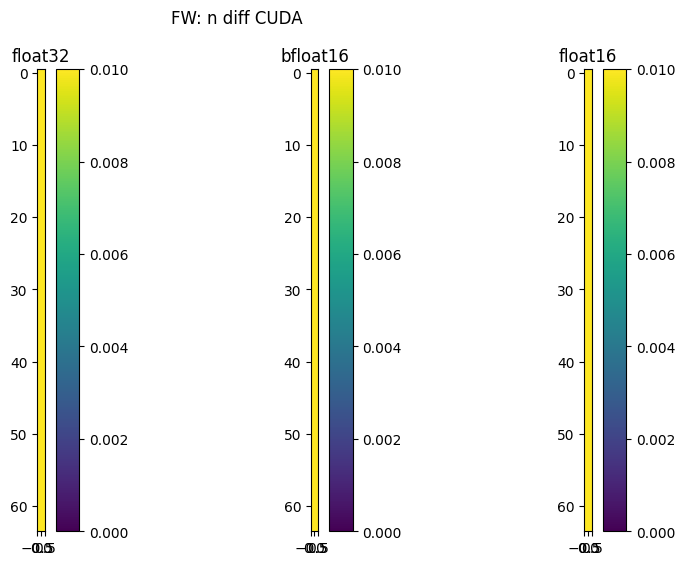

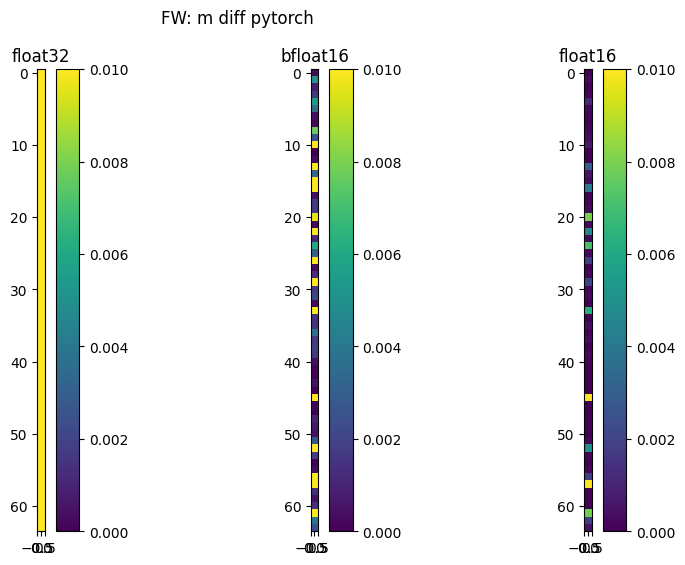

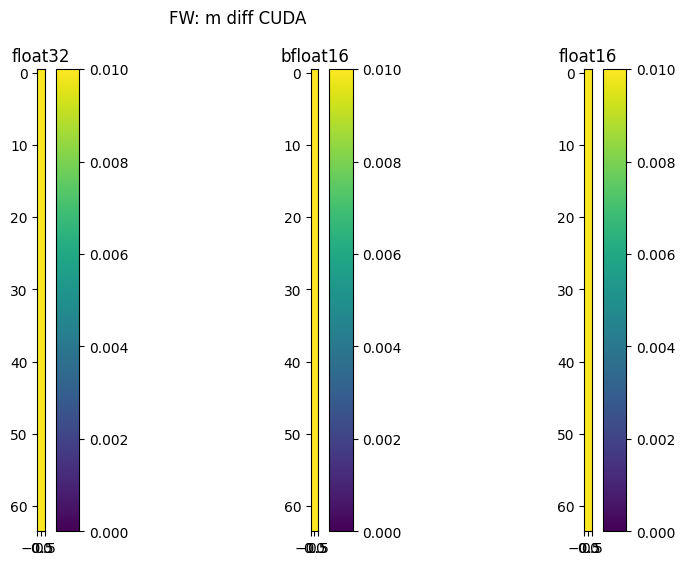

In [ ]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")

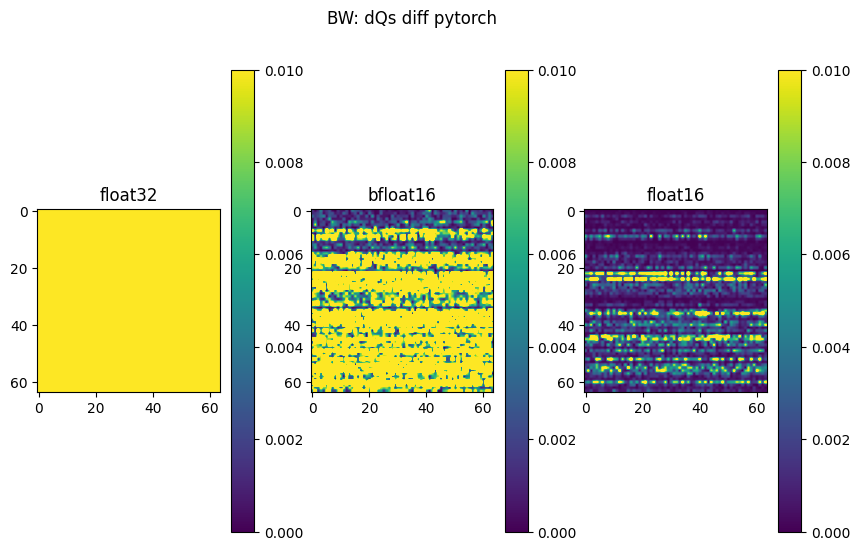

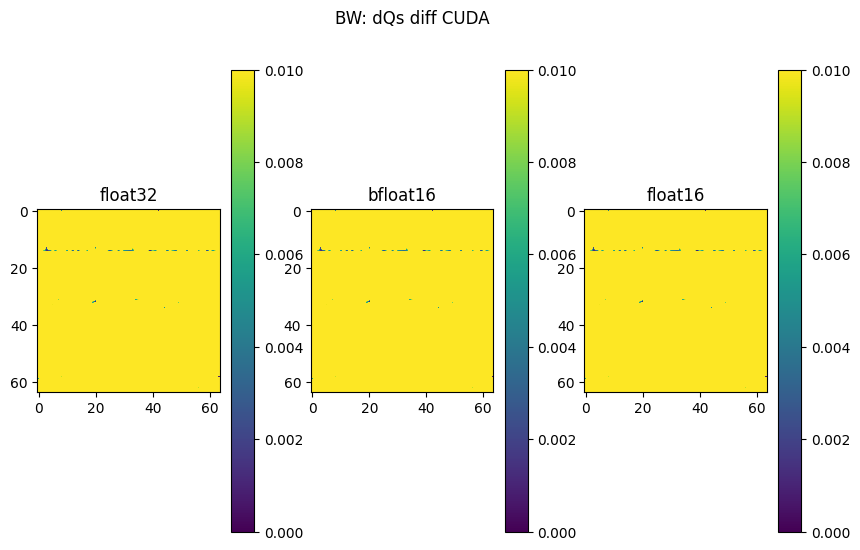

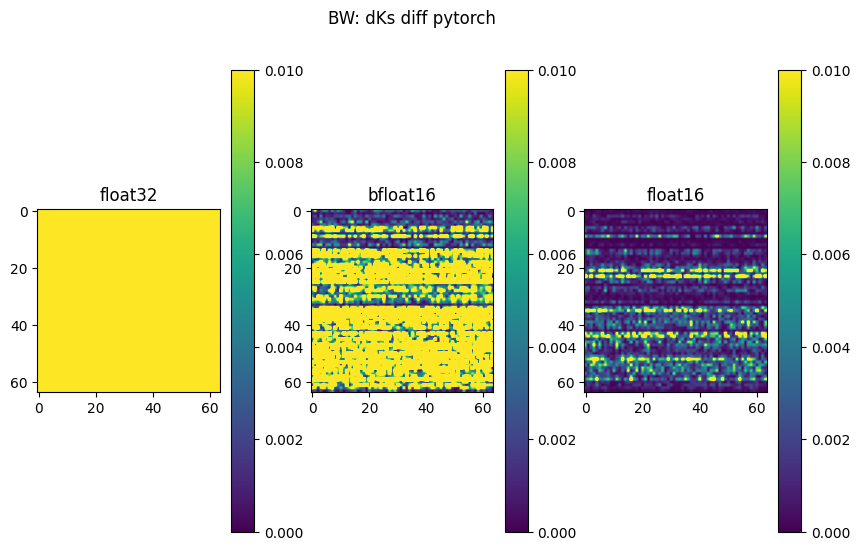

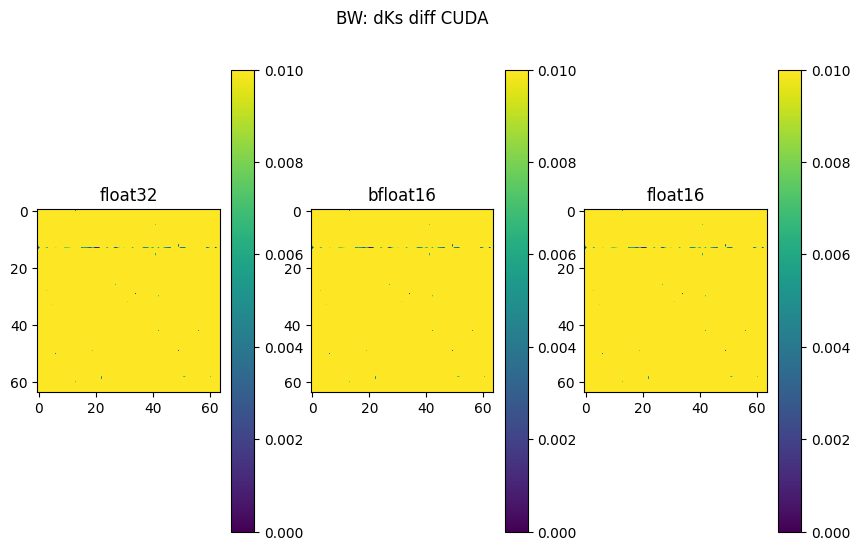

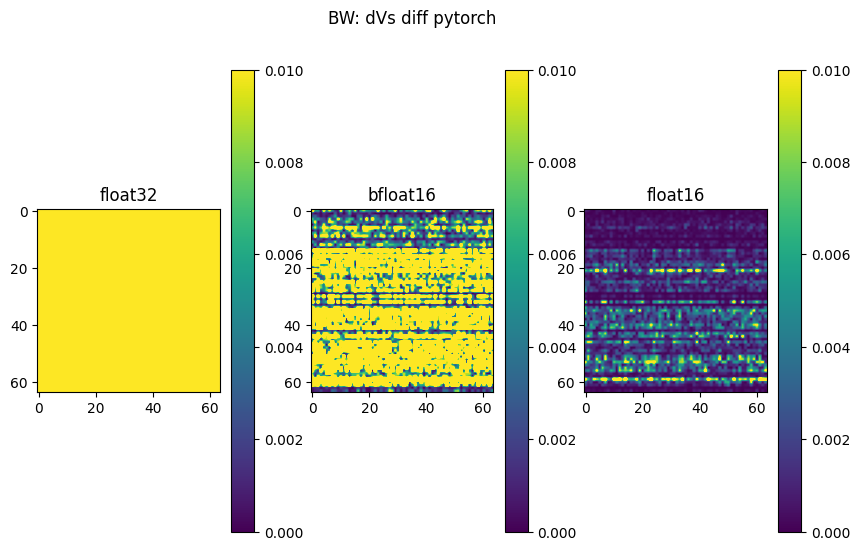

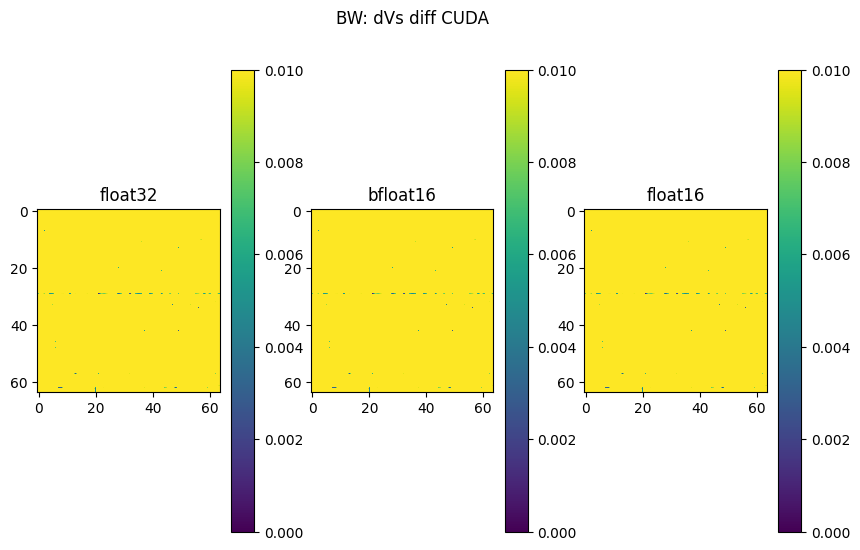

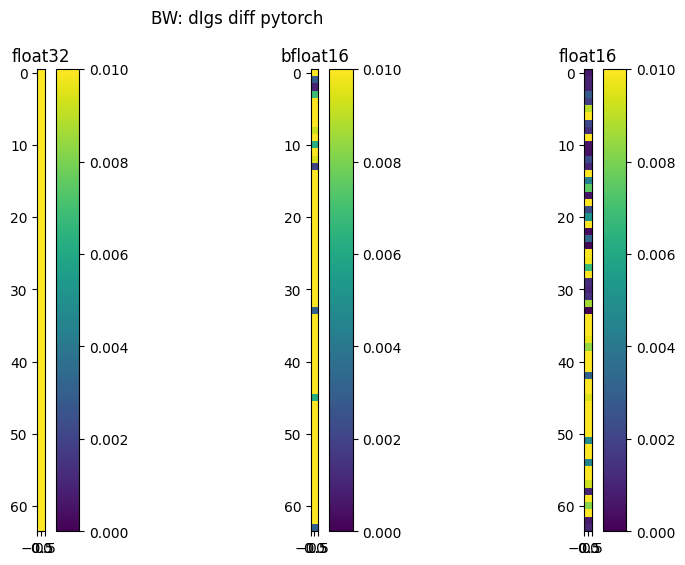

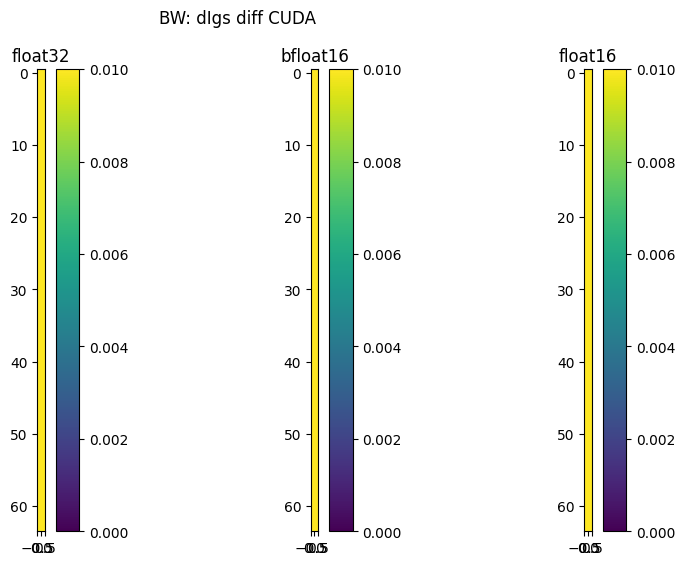

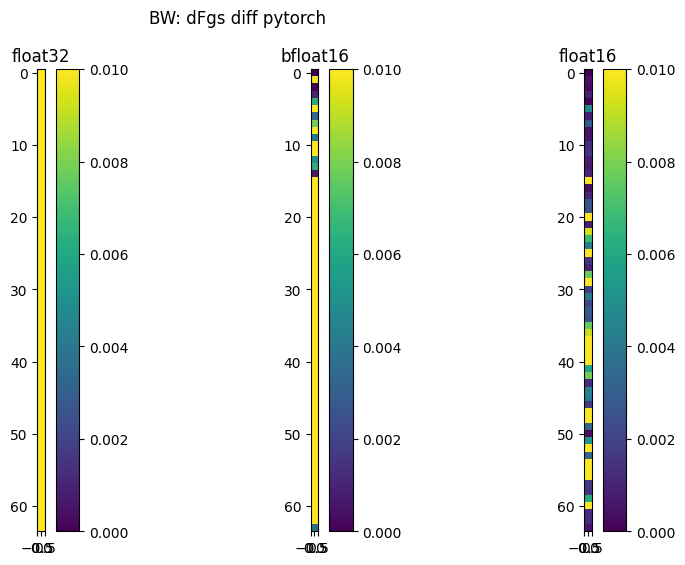

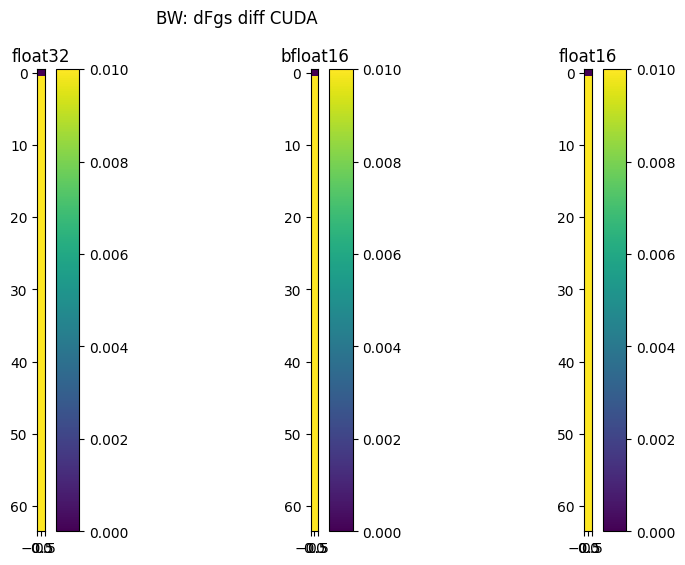

In [ ]:
# bw diffs
# dQs
fig = plot_numerical_diffs(dQs_pt, 10*torch.ones_like(dQs_pt), dQs_pt_bf16, dQs_pt_half, title="BW: dQs diff pytorch")
fig = plot_numerical_diffs(dQs_pt, dQs_cu, dQs_cu_bf16, dQs_cu_half, title="BW: dQs diff CUDA")
# dKs
fig = plot_numerical_diffs(dKs_pt, 10*torch.ones_like(dKs_pt), dKs_pt_bf16, dKs_pt_half, title="BW: dKs diff pytorch")
fig = plot_numerical_diffs(dKs_pt, dKs_cu, dKs_cu_bf16, dKs_cu_half, title="BW: dKs diff CUDA")
# dVs
fig = plot_numerical_diffs(dVs_pt, 10*torch.ones_like(dVs_pt), dVs_pt_bf16, dVs_pt_half, title="BW: dVs diff pytorch")
fig = plot_numerical_diffs(dVs_pt, dVs_cu, dVs_cu_bf16, dVs_cu_half, title="BW: dVs diff CUDA")
# dIgs
fig = plot_numerical_diffs(dIgs_pt, 10*torch.ones_like(dIgs_pt), dIgs_pt_bf16, dIgs_pt_half, title="BW: dIgs diff pytorch")
fig = plot_numerical_diffs(dIgs_pt, dIgs_cu, dIgs_cu_bf16, dIgs_cu_half, title="BW: dIgs diff CUDA")
# dFgs
fig = plot_numerical_diffs(dFgs_pt, 10*torch.ones_like(dFgs_pt), dFgs_pt_bf16, dFgs_pt_half, title="BW: dFgs diff pytorch")
fig = plot_numerical_diffs(dFgs_pt, dFgs_cu, dFgs_cu_bf16, dFgs_cu_half, title="BW: dFgs diff CUDA")

### Debug float16 precision differences in cuda kernel

In [ ]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 49792


In [ ]:
fgs

tensor([[[[-1.4286],
          [-1.0874],
          [ 0.5559],
          [ 1.0172],
          [-0.3479],
          [-1.3633],
          [-1.3168],
          [ 0.9415],
          [ 0.5776],
          [-0.4001],
          [-0.4550],
          [-0.5947],
          [-2.3788],
          [ 0.0537],
          [ 0.5271],
          [-0.2673],
          [ 0.1509],
          [ 0.3151],
          [-0.8073],
          [ 0.9548],
          [-0.7206],
          [ 0.2526],
          [ 0.8241],
          [-0.6592],
          [ 0.7642],
          [ 0.0181],
          [-0.6598],
          [ 0.6114],
          [ 0.2609],
          [-0.6826],
          [-0.8559],
          [-1.3082],
          [ 0.6555],
          [ 1.0994],
          [-3.3065],
          [ 1.0477],
          [ 1.7495],
          [ 0.0810],
          [-0.4557],
          [-1.1311],
          [-0.1796],
          [-1.4650],
          [ 0.1618],
          [-1.5969],
          [-0.5634],
          [ 0.1197],
          [ 0.1743],
          [-0

In [ ]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 25216


In [ ]:
print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matD_pt).tril())}")

====== Half ======
fw hs match: False, max diff: 4.586074352264404
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 0.0


In [ ]:
# matS = (qs @ ks.transpose(-2, -1) / (DH ** 0.5)).tril()
# matS[:,:, :, :10]

In [ ]:
# (matD_cu_half - matS)[:, :, :, :10]

In [ ]:
torch.nn.functional.logsigmoid(fgs_half)

tensor([[[[-1.6436],
          [-1.3779],
          [-0.4531],
          [-0.3086],
          [-0.8823],
          [-1.5908],
          [-1.5537],
          [-0.3293],
          [-0.4456],
          [-0.9131],
          [-0.9463],
          [-1.0342],
          [-2.4668],
          [-0.6665],
          [-0.4641],
          [-0.8359],
          [-0.6206],
          [-0.5479],
          [-1.1758],
          [-0.3257],
          [-1.1172],
          [-0.5747],
          [-0.3638],
          [-1.0762],
          [-0.3823],
          [-0.6841],
          [-1.0762],
          [-0.4336],
          [-0.5713],
          [-1.0918],
          [-1.2100],
          [-1.5479],
          [-0.4182],
          [-0.2874],
          [-3.3418],
          [-0.3005],
          [-0.1603],
          [-0.6533],
          [-0.9468],
          [-1.4102],
          [-0.7871],
          [-1.6729],
          [-0.6157],
          [-1.7812],
          [-1.0137],
          [-0.6353],
          [-0.6099],
          [-0

In [ ]:
torch.nn.functional.logsigmoid(fgs)

tensor([[[[-1.6434],
          [-1.3779],
          [-0.4533],
          [-0.3087],
          [-0.8822],
          [-1.5911],
          [-1.5542],
          [-0.3293],
          [-0.4455],
          [-0.9131],
          [-0.9463],
          [-1.0341],
          [-2.4675],
          [-0.6667],
          [-0.4639],
          [-0.8357],
          [-0.6205],
          [-0.5480],
          [-1.1761],
          [-0.3256],
          [-1.1170],
          [-0.5748],
          [-0.3637],
          [-1.0761],
          [-0.3823],
          [-0.6841],
          [-1.0765],
          [-0.4335],
          [-0.5712],
          [-1.0916],
          [-1.2100],
          [-1.5475],
          [-0.4182],
          [-0.2875],
          [-3.3424],
          [-0.3007],
          [-0.1603],
          [-0.6534],
          [-0.9467],
          [-1.4108],
          [-0.7870],
          [-1.6729],
          [-0.6155],
          [-1.7813],
          [-1.0140],
          [-0.6351],
          [-0.6098],
          [-0

In [ ]:
matD_cu_half[:,:, :, :10], matD_pt[:,:, :, :10]

(tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0.

### debug fw hs nans in last timesteps

In [ ]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 49792


In [ ]:
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

before kernel dispatch - float16!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 25216


In [ ]:
hs_cu_half[:, :, 20:30, :10]

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0', dtype=torch.float16)

In [ ]:
n_cu[:, :, 120:]

tensor([], device='cuda:0', size=(1, 1, 0, 1))

In [ ]:
(hs_cu-hs_pt)[:, :, 120:, :10]

tensor([], device='cuda:0', size=(1, 1, 0, 10))

In [ ]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: False, max diff: 4.586074352264404
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 0.0


### debug fw hs for Q64xKV64

**Not working:** Possible reason for Q64xKV64 we use too much shared memory than available on the the laptop gpu.

In [ ]:
# float32 just for reference
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 49792


In [ ]:
(hs_cu - hs_pt)[:,:, :10, :10] 

tensor([[[[ 0.4050,  0.7122, -0.5808, -0.2258, -0.3323, -0.5197,  0.4062, -1.2899, -0.1422, -0.1686],
          [-0.2046, -0.2024, -0.0727, -0.5500, -0.5329,  0.2849,  0.3680,  0.4828, -0.0630, -0.0876],
          [-0.2582, -0.6013,  0.0127,  0.0388, -0.1760,  0.0387, -0.1193,  0.5082, -0.4896, -0.0524],
          [-0.5550,  0.2004, -0.0763, -0.9849,  2.1049, -0.8376, -1.9568,  0.3251,  0.0979, -1.0263],
          [ 0.4308,  0.4886,  0.1588,  0.3175, -0.2687,  0.3128,  0.5872, -0.4546,  0.6618,  0.4594],
          [-0.7483,  0.2502, -0.8848,  0.7814,  1.4765,  0.3797, -0.4529, -2.3476, -0.7402, -0.9797],
          [ 0.6957, -1.2417,  0.3549, -0.6771, -0.1758, -0.4408,  0.2014,  0.8711,  0.0295,  0.1891],
          [-0.0929, -0.7834, -0.9729,  0.0701, -0.2269, -0.7266, -0.4952,  0.5034, -1.1082,  0.7101],
          [-0.2243,  0.4668,  0.0938,  0.1267,  0.1751,  0.2747, -0.0258, -0.4668,  0.0290, -0.1790],
          [ 1.0779, -0.0184,  0.0341,  0.5225,  0.2355, -0.8241, -0.0382, -0.1174,

In [ ]:
(hs_cu)[:,:, :8, :10] 

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], device='cuda:0')

In [ ]:
(hs_pt)[:,:, :8, :10] 

tensor([[[[-0.4050, -0.7122,  0.5808,  0.2258,  0.3323,  0.5197, -0.4062,  1.2899,  0.1422,  0.1686],
          [ 0.2046,  0.2024,  0.0727,  0.5500,  0.5329, -0.2849, -0.3680, -0.4828,  0.0630,  0.0876],
          [ 0.2582,  0.6013, -0.0127, -0.0388,  0.1760, -0.0387,  0.1193, -0.5082,  0.4896,  0.0524],
          [ 0.5550, -0.2004,  0.0763,  0.9849, -2.1049,  0.8376,  1.9568, -0.3251, -0.0979,  1.0263],
          [-0.4308, -0.4886, -0.1588, -0.3175,  0.2687, -0.3128, -0.5872,  0.4546, -0.6618, -0.4594],
          [ 0.7483, -0.2502,  0.8848, -0.7814, -1.4765, -0.3797,  0.4529,  2.3476,  0.7402,  0.9797],
          [-0.6957,  1.2417, -0.3549,  0.6771,  0.1758,  0.4408, -0.2014, -0.8711, -0.0295, -0.1891],
          [ 0.0929,  0.7834,  0.9729, -0.0701,  0.2269,  0.7266,  0.4952, -0.5034,  1.1082, -0.7101]]]], device='cuda:0')

In [ ]:
(matD_cu - matD_pt)[:,:, :10, :10] 

tensor([[[[-1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.0000e+00, -9.1548e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.3850e-01, -1.2679e-01, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.5581e-02, -5.0883e-02, -4.0131e-01, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.5581e-02, -5.0883e-02, -4.0131e-01, -1.0000e+00, -8.0032e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.4947e-02, -3.1993e-02, -2.5233e-01, -6.2876e-01, -5.0321e-01, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.2326e-03, -2.9594e-03, -2.3340e-02, -5.8161e-02, -4.6547e-02, -9.2500e-02, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [ ]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: False, max diff: 4.586074352264404
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 0.0


In [ ]:
(matD_pt_half - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -4.3637e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 5.0411e-05,  3.8266e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.8959e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.3111e-05, -1.0185e-05,  5.8889e-05,  0.0000e+00, -1.0080e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 8.6937e-05,  1.9595e-05,  6.0183e-04,  2.0962e-03,  6.9177e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 3.3574e-07, -4.9016e-06,  3.6132e-05,  2.8056e-04,  5.2996e-05, -3.1762e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [ ]:
(matD_pt_bf16 - matD_pt)[:,:, :10, :10]

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.3192e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.1490e-03,  1.6034e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -9.1767e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.6103e-04, -3.4588e-04, -2.8708e-03,  0.0000e+00, -3.4494e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-7.6756e-04,  2.3322e-04, -2.3279e-03,  1.4311e-04, -5.1676e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.5034e-04, -1.5177e-04, -1.4697e-04, -5.5138e-05, -4.0477e-04, -7.0315e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [ ]:
(matD_pt_bf16)[:,:, :10, :10]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1016e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3965e-01, 1.2695e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 4.0039e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5420e-02, 5.0537e-02, 3.9844e-01, 1.0000e+00, 7.9688e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4180e-02, 3.2227e-02, 2.5000e-01, 6.2891e-01, 4.9805e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.0823e-03, 2.8076e-03, 2.3193e-02, 5.8105e-02, 4.6143e-02, 9.1797e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2054e-03, 1.0986e-03, 8.9111e-03, 2.2095e-02, 1.7700e-02, 3.540

### debug q16xkv16 tile size backward

In [ ]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)
dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_C_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt = vlstm_bw_torch_obw(
    delta_Htilde=dHs,
    queries=qs,
    keys=ks,
    values=vs,
    igate_preact=igs,
    fgate_preact=fgs,
    var_n=n_pt,
    var_m=m_pt,
)
dQs_pt.dtype

torch.float32

In [ ]:
# cuda kernel float32
hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)
dQs_cu, dKs_cu, dVs_cu, dIgs_cu, dFgs_cu, matC_cu = vlstm_bw_cuda(
    mat_delta_H=dHs,
    mat_Q=qs,
    mat_K=ks,
    mat_V=vs,
    vec_igp=igs,
    vec_fgp=fgs,
    vec_n=n_cu,
    vec_m=m_cu,
)

before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 49792
before kernel dispatch - float32!
B: 1, NH: 1, S: 64, DH: 64
blocksxy: 1-2, threadsxy: 16-16, shared_mem in bytes: 83840


In [ ]:
# mat_P_pt[:, :, :16, :9]

In [ ]:
# mat_R_pt[:, :, :16, :9]

In [ ]:
delta_C_pt[:, :, :16, :9]

tensor([[[[ 3.5446e+00,  9.3890e+00, -1.0794e+01,  5.7111e+00,  1.1123e+01,  1.4995e+01, -8.4937e+00, -5.5302e+00,  9.9723e+00],
          [ 1.6856e+00, -6.7893e-01,  9.9872e-01,  2.8166e+00,  2.5863e+00,  3.5257e+00, -1.0102e+00, -2.0186e+00,  1.6968e+00],
          [ 3.2581e+00,  1.5814e+01, -4.9207e+00,  1.3572e+01, -8.4559e+00, -2.7868e-01, -3.3076e+00, -6.7055e+00,  2.4092e+01],
          [-5.5497e+00, -3.7048e+00, -1.4962e+01, -3.9715e+00, -1.7804e+00, -3.5149e+00,  1.6432e+00, -7.3078e+00,  1.1947e+01],
          [ 2.7410e+00,  8.7551e+00,  5.9940e+00,  2.0594e+00, -4.7773e+00,  3.2997e+00,  4.4713e+00,  1.9981e+01,  1.3639e+01],
          [-7.8685e-01, -9.6627e-01, -2.3325e+00,  3.0508e+00,  2.5648e+00,  3.3735e+00, -1.7539e+00,  1.8021e+00,  2.0408e+00],
          [-6.6323e-01, -5.4699e-01, -8.9419e+00,  2.5816e+00, -7.7686e-01,  7.4290e+00, -6.2936e+00, -2.7966e-02, -6.9235e+00],
          [ 1.2989e-01,  1.5255e+01,  1.1522e+01,  1.1997e+01,  1.7870e-01, -2.1277e+00, -2.4522e

In [ ]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)
matS[:,:, :16, :9], (matC_cu-matS).abs().max() #(matC_cu-matS)[:,:,:16,:9]

(tensor([[[[ 5.8842e-01,  1.5230e+00, -4.2416e-01, -4.7735e-01, -5.5120e-01, -2.0461e+00, -9.9602e-02, -3.8225e-02, -1.2008e+00],
           [-6.1592e-01,  1.3469e+00, -1.2783e+00,  4.3127e-01,  1.2174e-01, -2.2152e-01,  1.5031e+00,  9.6469e-01,  1.7736e-01],
           [-6.7692e-01, -2.7050e-02,  1.6436e-01,  4.6874e-03, -8.2658e-01, -1.2596e-01,  1.8381e+00, -1.8716e+00, -9.4941e-01],
           [-8.4047e-01, -2.0120e-01, -8.8712e-01,  1.5097e+00, -7.4904e-01,  1.9217e+00, -3.4015e-01,  1.4220e+00,  7.6952e-01],
           [ 1.9399e-01, -3.7498e-01, -4.7543e-01, -3.9140e-01, -2.3347e-02, -7.8092e-01, -6.7870e-01, -5.6295e-01,  7.1369e-01],
           [ 1.0479e+00,  7.2010e-01,  1.7666e-01,  4.8417e-01,  2.7092e+00, -2.6374e+00,  1.2788e+00, -1.1182e+00,  2.9288e-01],
           [-1.0582e+00, -1.0769e+00,  3.1240e-01,  3.3122e-01,  1.3031e+00, -4.1286e-01,  1.4592e+00, -2.6718e-01,  1.3288e+00],
           [ 1.2720e+00,  9.5645e-01,  1.1383e+00,  1.0739e+00, -3.5134e-01,  5.6268e-01, 

In [ ]:
matD_pt[:, :, :16, :9]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.0000e+00, 9.1548e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.3850e-01, 1.2679e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [5.5581e-02, 5.0883e-02, 4.0131e-01, 1.0000e+00, 8.0032e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.4947e-02, 3.1993e-02, 2.5233e-01, 6.2876e-01, 5.0321e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [3.2326e-03, 2.9594e-03, 2.3340e-02, 5.8161e-02, 4.6547e-02, 9.2500e-02, 1.0000e+00, 0.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.7981e-03, 2.1923e-02, 1.7546e-02, 3.4868e-02, 3.7695e-01, 1.0000e+00, 0.0000e+00],
          [1.2185e-03, 1.1155e-03, 8.798

In [ ]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")
print(f"---------------------------------")
print(f"bw dQs match: {torch.allclose(dQs_cu, dQs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dQs_cu - dQs_pt))}")
print(f"bw dKs match: {torch.allclose(dKs_cu, dKs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dKs_cu - dKs_pt))}")
print(f"bw dVs match: {torch.allclose(dVs_cu, dVs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dVs_cu - dVs_pt))}")
print(f"bw dIgs match: {torch.allclose(dIgs_cu, dIgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dIgs_cu - dIgs_pt))}")
print(f"bw dFgs match: {torch.allclose(dFgs_cu, dFgs_pt, rtol=BW_RTOL, atol=BW_ATOL)}, max diff: {torch.max(torch.abs(dFgs_cu - dFgs_pt))}")

Match against pt float32:
====== Full ======
fw hs match: False, max diff: 4.586074352264404
fw n match: False, max diff: 3.7951691150665283
fw m match: False, max diff: 2.3591573238372803
fw D match: False, max diff: 55.879150390625
---------------------------------
bw dQs match: False, max diff: 13.540014266967773
bw dKs match: False, max diff: 10.152042388916016
bw dVs match: False, max diff: 6.6032633781433105
bw dIgs match: False, max diff: 16.943340301513672
bw dFgs match: False, max diff: 9.2593412399292


In [ ]:
# dQs_pt, dKs_pt, dVs_pt, dIgs_pt, dFgs_pt, delta_D_pt, delta_Dtilde_pt, delta_fbar_pt, mat_P_pt, mat_R_pt

In [ ]:
mat_P_pt[:, :, -20:, :10]

tensor([[[[-3.8014e-18, -2.6029e-17, -9.0818e-18,  2.6597e-16, -3.7876e-16, -5.1729e-16,  4.2590e-15, -1.8653e-14,  7.6347e-15, -5.1986e-15],
          [ 1.6119e-18, -4.9770e-18,  8.1044e-17,  2.2771e-16, -4.2698e-17,  1.3762e-16,  4.6398e-15, -1.0305e-14,  2.4711e-15,  3.1240e-13],
          [ 7.7549e-19,  4.6317e-18,  8.9727e-18, -1.3626e-16, -6.1120e-17, -1.8881e-17, -9.5002e-17,  4.1580e-15, -6.6336e-15,  2.9651e-14],
          [-1.5598e-18, -1.6937e-18,  4.9546e-17,  1.4132e-17, -9.5480e-17, -7.0841e-17,  1.0731e-15, -1.4578e-15,  1.7619e-15, -7.3600e-14],
          [-4.0530e-19,  1.0657e-18, -1.1045e-18, -1.3626e-17,  1.5528e-17,  1.3433e-17, -4.5306e-18,  4.9394e-16,  4.1215e-18,  7.9599e-16],
          [-3.9307e-19, -1.6109e-19, -7.0548e-19, -5.2976e-18,  8.1807e-18, -2.8884e-17, -3.1271e-17, -4.8939e-17, -1.2959e-16,  3.2036e-15],
          [-9.3168e-20,  1.2765e-19,  2.2086e-19, -2.6456e-18,  1.4891e-18,  3.4908e-18, -1.1672e-17, -6.8242e-19,  1.4392e-16,  4.3201e-16],
      

In [ ]:
matC_cu[:, :, -20:, :10]

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0

In [ ]:
(matC_cu-mat_P_pt)[:, :, -20:, :10], torch.abs((matC_cu-mat_P_pt)).max()

(tensor([[[[ 3.8014e-18,  2.6029e-17,  9.0818e-18, -2.6597e-16,  3.7876e-16,  5.1729e-16, -4.2590e-15,  1.8653e-14, -7.6347e-15,  5.1986e-15],
           [-1.6119e-18,  4.9770e-18, -8.1044e-17, -2.2771e-16,  4.2698e-17, -1.3762e-16, -4.6398e-15,  1.0305e-14, -2.4711e-15, -3.1240e-13],
           [-7.7549e-19, -4.6317e-18, -8.9727e-18,  1.3626e-16,  6.1120e-17,  1.8881e-17,  9.5002e-17, -4.1580e-15,  6.6336e-15, -2.9651e-14],
           [ 1.5598e-18,  1.6937e-18, -4.9546e-17, -1.4132e-17,  9.5480e-17,  7.0841e-17, -1.0731e-15,  1.4578e-15, -1.7619e-15,  7.3600e-14],
           [ 4.0530e-19, -1.0657e-18,  1.1045e-18,  1.3626e-17, -1.5528e-17, -1.3433e-17,  4.5306e-18, -4.9394e-16, -4.1215e-18, -7.9599e-16],
           [ 3.9307e-19,  1.6109e-19,  7.0548e-19,  5.2976e-18, -8.1807e-18,  2.8884e-17,  3.1271e-17,  4.8939e-17,  1.2959e-16, -3.2036e-15],
           [ 9.3168e-20, -1.2765e-19, -2.2086e-19,  2.6456e-18, -1.4891e-18, -3.4908e-18,  1.1672e-17,  6.8242e-19, -1.4392e-16, -4.3201e-16],

In [ ]:
(matC_cu-mat_R_pt)[:, :, -20:, :10], torch.abs((matC_cu-mat_R_pt)).max()

(tensor([[[[-1.1921e-18, -2.9275e-19, -1.3582e-18, -2.2830e-17, -1.9130e-18,  6.3865e-17,  4.6712e-16, -8.4738e-16, -1.3291e-15,  2.3800e-14],
           [ 3.4214e-18, -2.6666e-18,  1.3577e-17,  1.0556e-16, -1.5683e-17,  1.2029e-17,  7.9254e-16,  1.3827e-15,  1.1013e-15, -1.9413e-14],
           [ 2.0326e-19, -4.6310e-19, -1.1311e-19, -5.8003e-18,  3.4609e-17, -8.8404e-18,  2.9798e-16, -1.4066e-15, -2.2394e-16, -2.7243e-15],
           [-2.5461e-19, -6.5266e-19, -1.1740e-18,  2.3278e-19,  1.9842e-18,  3.9170e-18,  6.2699e-17,  4.8642e-16,  8.4011e-17, -3.5111e-15],
           [-1.3363e-19,  7.4390e-20,  7.4008e-19,  1.8466e-18, -1.3334e-18,  6.2079e-19,  4.2460e-17,  2.3087e-17, -5.7968e-17, -4.8080e-16],
           [ 1.8793e-20,  3.1826e-20,  8.9419e-19,  1.7605e-18,  2.1679e-18, -1.5327e-18,  4.2292e-17,  1.4367e-16,  4.8086e-18, -3.1885e-16],
           [ 2.1766e-20, -2.1087e-20, -1.1880e-20,  8.2113e-19,  8.6548e-20, -6.4593e-19,  1.2026e-17, -1.5351e-18,  1.1483e-17, -3.3266e-16],

In [ ]:
matS = qs @ ks.transpose(-2, -1) / (DH ** 0.5)

In [ ]:
(matC_cu-matS)[:, :, -20:, :10], torch.abs((matC_cu-matS)).max()

(tensor([[[[-0.4783, -0.1283, -0.0755, -0.5091, -0.0533,  0.8954,  0.6058, -0.4143, -1.1559,  1.0528],
           [ 1.3726, -1.1686,  0.7544,  2.3538, -0.4370,  0.1686,  1.0278,  0.6760,  0.9578, -0.8587],
           [ 0.2340, -0.5823, -0.0180, -0.3711,  2.7669, -0.3557,  1.1089, -1.9731, -0.5589, -0.3458],
           [-0.5722, -1.6022, -0.3654,  0.0291,  0.3097,  0.3076,  0.4555,  1.3320,  0.4093, -0.8700],
           [-0.7424,  0.4514,  0.5694,  0.5702, -0.5144,  0.1205,  0.7625,  0.1563, -0.6981, -0.2945],
           [ 0.1867,  0.3454,  1.2303,  0.9721,  1.4957, -0.5321,  1.3582,  1.7392,  0.1036, -0.3492],
           [ 0.7037, -0.7447, -0.0532,  1.4755,  0.1943, -0.7298,  1.2568, -0.0605,  0.8048, -1.1858],
           [ 0.2600, -0.6857, -0.9192, -0.7971, -1.0043, -0.1310,  0.1827, -1.3351, -0.7762, -1.3722],
           [-1.0719, -0.3125, -0.5756,  0.9068,  2.4393, -1.3669, -0.6909,  1.4351, -0.4237,  0.6652],
           [-0.2223, -1.9374,  1.6431, -0.5624,  0.1246,  0.0095, -0.6734

In [ ]:
(matC_cu-delta_Dtilde_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_Dtilde_pt)).max()

(tensor([[[[ 1.8180e-18,  3.3393e-18,  6.8538e-19, -1.3540e-16,  2.0188e-17, -4.6319e-16,  2.5801e-15,  7.7269e-15, -8.8249e-15, -5.4728e-15],
           [ 2.2126e-18,  5.8161e-18,  6.1142e-17,  5.3598e-16,  1.8657e-17,  2.3209e-17,  4.7690e-15, -6.9655e-15,  2.3667e-15, -2.6827e-13],
           [ 1.8145e-19, -2.6971e-18, -1.6181e-19,  5.0568e-17, -1.6911e-16,  6.7151e-18, -1.0535e-16, -8.2041e-15,  3.7072e-15, -1.0253e-14],
           [ 8.9254e-19,  2.7136e-18, -1.8104e-17,  4.1090e-19, -2.9569e-17, -2.1793e-17,  4.8879e-16, -1.9418e-15,  7.2110e-16,  6.4031e-14],
           [ 3.0088e-19,  4.8108e-19, -6.2895e-19, -7.7694e-18, -7.9885e-18,  1.6190e-18, -3.4547e-18,  7.7195e-17, -2.8773e-18, -2.3442e-16],
           [-7.3383e-20, -5.5634e-20, -8.6797e-19, -5.1498e-18,  1.2235e-17,  1.5369e-17, -4.2472e-17, -8.5113e-17, -1.3420e-17, -1.1188e-15],
           [-6.5563e-20, -9.5058e-20, -1.1749e-20, -3.9036e-18,  2.8937e-19, -2.5476e-18, -1.4670e-17,  4.1269e-20,  1.1583e-16, -5.1227e-16],

In [ ]:
(matC_cu-delta_D_pt)[:, :, -20:, :10], torch.abs((matC_cu-delta_D_pt)).max()

(tensor([[[[ 7.2938e-01,  1.4634e+00,  3.8083e-02, -3.0191e+00,  5.6248e-01, -6.4941e+00,  3.3462e+00,  3.7774e+00, -7.6751e+00, -2.4208e-01],
           [ 8.8767e-01,  2.5488e+00,  3.3973e+00,  1.1952e+01,  5.1983e-01,  3.2540e-01,  6.1849e+00, -3.4052e+00,  2.0584e+00, -1.1866e+01],
           [ 2.0889e-01, -3.3915e+00, -2.5798e-02,  3.2355e+00, -1.3520e+01,  2.7015e-01, -3.9203e-01, -1.1508e+01,  9.2515e+00, -1.3013e+00],
           [ 2.0058e+00,  6.6614e+00, -5.6350e+00,  5.1325e-02, -4.6149e+00, -1.7116e+00,  3.5510e+00, -5.3176e+00,  3.5130e+00,  1.5866e+01],
           [ 1.6715e+00,  2.9193e+00, -4.8392e-01, -2.3990e+00, -3.0821e+00,  3.1433e-01, -6.2042e-02,  5.2257e-01, -3.4651e-02, -1.4359e-01],
           [-7.2901e-01, -6.0372e-01, -1.1942e+00, -2.8435e+00,  8.4415e+00,  5.3359e+00, -1.3639e+00, -1.0303e+00, -2.8900e-01, -1.2255e+00],
           [-2.1197e+00, -3.3570e+00, -5.2606e-02, -7.0145e+00,  6.4970e-01, -2.8784e+00, -1.5332e+00,  1.6258e-03,  8.1177e+00, -1.8260e+00],

In [ ]:
(matC_cu-matD_pt)[:, :, :20, :10]

tensor([[[[-1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.0000e+00, -9.1548e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.3850e-01, -1.2679e-01, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.5581e-02, -5.0883e-02, -4.0131e-01, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.5581e-02, -5.0883e-02, -4.0131e-01, -1.0000e+00, -8.0032e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.4947e-02, -3.1993e-02, -2.5233e-01, -6.2876e-01, -5.0321e-01, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.2326e-03, -2.9594e-03, -2.3340e-02, -5.8161e-02, -4.6547e-02, -9.2500e-02, -1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
      

In [ ]:
(dQs_cu - dQs_pt)[:,:,:10, :10]

tensor([[[[ 2.8091e-01,  2.8496e-01,  2.8446e-01,  6.4118e-01, -1.9703e-01,  2.6907e-01,  3.9302e-01,  4.2016e-01,  1.6143e-03,  2.0366e-01],
          [ 1.5318e-01,  1.3423e-01,  3.0690e-02,  3.0721e-01, -2.1062e-01,  1.2470e-01,  1.2109e-01,  2.5331e-01,  9.2412e-02,  6.4234e-02],
          [-1.0200e+00,  6.9763e-01,  7.3111e-02, -5.5890e-01, -4.6800e-01, -2.0081e-01,  1.6455e+00,  1.3671e-01,  8.4307e-02,  3.5517e-01],
          [-1.3669e+00,  8.8836e-01, -3.1731e-01, -7.9063e-01, -8.2054e-01, -3.3576e-01,  2.0066e+00, -4.9760e-01,  5.1125e-01, -1.2828e-01],
          [ 4.1765e-01, -7.2948e-01,  1.0884e-01,  5.1022e-01,  8.8160e-02,  3.8606e-02, -8.1193e-01, -9.8480e-01,  4.0413e-01, -2.0247e-01],
          [ 3.8641e-01,  1.0057e+00, -1.8380e-01,  3.1818e-01, -3.7080e-01,  2.8908e-01,  6.8346e-02,  3.2552e-01,  2.2996e-01, -3.8769e-01],
          [-4.9861e-01, -2.3372e-01,  2.7324e-01,  6.9262e-01, -1.5126e-01,  1.6267e+00,  3.8521e-01,  1.1752e+00,  3.0159e-01,  5.5234e-01],
      